# Importação de bibliotecas

In [320]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback

sns.set_style("whitegrid")

In [321]:
SEED = 667430
porcentagem = lambda x: f"{round(x*100 if x <= 1 else x, 2)}%"

# Importação de dados

In [322]:
fonte = (
    "./dados/breast-cancer.data"
    or "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.data"
)

df = pd.read_csv(fonte, header=None)
colunas = [
    "saida",
    "idade",
    "menopausa",
    "tamanho_tumor",
    "linfonodos",
    "penetracao_linfonodo",
    "grau_malignidade",
    "seio",
    "seio_quadrante",
    "radioterapia",
]

df.columns = colunas
df.head(3)

,saida,idade,menopausa,tamanho_tumor,linfonodos,penetracao_linfonodo,grau_malignidade,seio,seio_quadrante,radioterapia
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no


# Exploração dos dados

In [323]:
df.isnull().sum()

saida                   0
idade                   0
menopausa               0
tamanho_tumor           0
linfonodos              0
penetracao_linfonodo    0
grau_malignidade        0
seio                    0
seio_quadrante          0
radioterapia            0
dtype: int64

In [324]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   saida                 286 non-null    object
 1   idade                 286 non-null    object
 2   menopausa             286 non-null    object
 3   tamanho_tumor         286 non-null    object
 4   linfonodos            286 non-null    object
 5   penetracao_linfonodo  286 non-null    object
 6   grau_malignidade      286 non-null    int64 
 7   seio                  286 non-null    object
 8   seio_quadrante        286 non-null    object
 9   radioterapia          286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


In [325]:
df.nunique()

saida                    2
idade                    6
menopausa                3
tamanho_tumor           11
linfonodos               7
penetracao_linfonodo     3
grau_malignidade         3
seio                     2
seio_quadrante           6
radioterapia             2
dtype: int64

In [326]:
for column in df.columns:
    print(column, df[column].unique())

saida ['no-recurrence-events' 'recurrence-events']
idade ['30-39' '40-49' '60-69' '50-59' '70-79' '20-29']
menopausa ['premeno' 'ge40' 'lt40']
tamanho_tumor ['30-34' '20-24' '15-19' '0-4' '25-29' '50-54' '10-14' '40-44' '35-39'
 '5-9' '45-49']
linfonodos ['0-2' '6-8' '9-11' '3-5' '15-17' '12-14' '24-26']
penetracao_linfonodo ['no' 'yes' '?']
grau_malignidade [3 2 1]
seio ['left' 'right']
seio_quadrante ['left_low' 'right_up' 'left_up' 'right_low' 'central' '?']
radioterapia ['no' 'yes']


In [327]:
df.penetracao_linfonodo[df.penetracao_linfonodo == '?'].count()

8

In [328]:
df.seio_quadrante[df.seio_quadrante == '?'].count()

1

In [329]:
df = df.drop(df[df.penetracao_linfonodo == '?'].index)
df = df.drop(df[df.seio_quadrante  == '?'].index)

# Limpeza de dados e modelagem do *dataset*

## Exclusão de colunas

O seio e o seu quadrante nada importam para o modelo, pois anatomicamente ambos são praticamente identicos.

Tal conclusão se baseia nos seguintes fatos:

* Não foi encontrado nenhum artigo que explique uma suposta correlação entre o lado/quadrante do seio e o câncer de mama.

* Apesar de existirem naturalmente algumas assimetrias nas mamas, elas são extremamente semelhantes e praticamente simétricas internamente, o que permite concluir que pouco importa qual mama foi afetada pelo câncer.

Artigo sobre anatomia: "Anatomy of the Breast" - https://www.mskcc.org/cancer-care/types/breast/anatomy-breast

## Colunas mantidas

As outras colunas foram mantidas e, portanto, estão embasadas pelos artigos abaixo:

`idade`: "Age and Cancer Risk" - https://www.cancer.gov/about-cancer/causes-prevention/risk/age

`menopausa`: "Impact of menopausal status on risk of metastatic recurrence of
breast cancer" - https://www.breastcancerregister.org.nz/images/assets/3940/1/impact_of_menopausal_status_on_risk_of_metastatic.4.pdf 

`tamanho_tumor`: "Tumor Size Still Impacts Prognosis in Breast Cancer With Extensive Nodal Involvement" - https://www.frontiersin.org/articles/10.3389/fonc.2021.585613/full

`linfonodos`: "Impact of Number of Positive Lymph Nodes and Lymph Node Ratio on Survival of Women with Node-Positive Breast Cancer" - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6456272/

`penetracao_linfonodo`:"Comparison of AJCC Anatomic and Clinical Prognostic Stage Groups in Breast Cancer: Analysis of 3322 Cases From a Single Institution" - https://www.sciencedirect.com/science/article/abs/pii/S1526820918302301

`grau_malignidade`: "Prognosis in Carcinoma of the Breast" - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2007665/pdf/brjcancer00404-0003.pdf

`radioterapia`: "Shorter Course of Radiation Is Effective, Safe for Some with Early-Stage Breast Cancer" - https://www.cancer.gov/news-events/cancer-currents-blog/2022/early-breast-cancer-shorter-radiation-therapy

In [330]:
df.drop(columns=["seio", "seio_quadrante"], inplace=True)
df.head(3)

,saida,idade,menopausa,tamanho_tumor,linfonodos,penetracao_linfonodo,grau_malignidade,radioterapia
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,no


In [331]:
filtro = lambda x: 0 if "no" in x else 1
df.saida = df.saida.apply(filtro)
df.penetracao_linfonodo = df.penetracao_linfonodo.apply(filtro)
df.radioterapia = df.radioterapia.apply(filtro)

In [332]:
df.head(3)

,saida,idade,menopausa,tamanho_tumor,linfonodos,penetracao_linfonodo,grau_malignidade,radioterapia
0,0,30-39,premeno,30-34,0-2,0,3,0
1,0,40-49,premeno,20-24,0-2,0,2,0
2,0,40-49,premeno,20-24,0-2,0,2,0


In [333]:
colunas_descritivas = ["idade", "menopausa", "tamanho_tumor", "linfonodos"]
df[colunas_descritivas].nunique().sum()

27

### Função para plotar gráficos de barras comparando colunas com e sem recorrências

In [334]:
def plotar_barras(coluna: str, titulo: str = None) -> None:
    com_recorrencia = df[coluna].where(df.saida == 1).value_counts()
    sem_recorrencia = df[coluna].where(df.saida == 0).value_counts()

    plt.bar(sem_recorrencia.keys(), sem_recorrencia.values, color="green", alpha=0.8)
    plt.bar(com_recorrencia.keys(), com_recorrencia.values, color="red", alpha=0.7)

    if titulo:
        plt.title(titulo)

    plt.show()

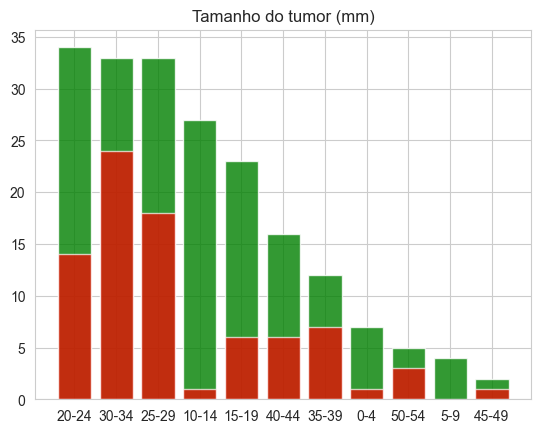

In [335]:
plotar_barras("tamanho_tumor", "Tamanho do tumor (mm)")

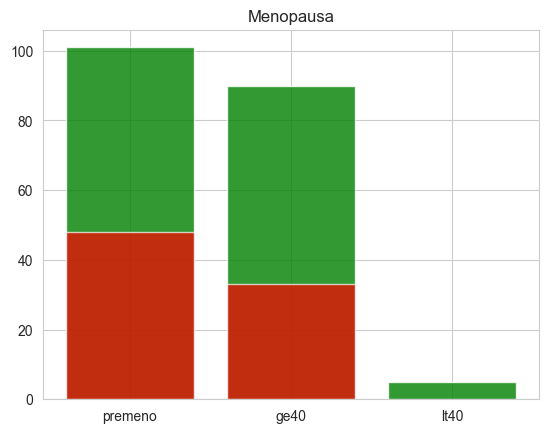

In [336]:
plotar_barras("menopausa", "Menopausa")

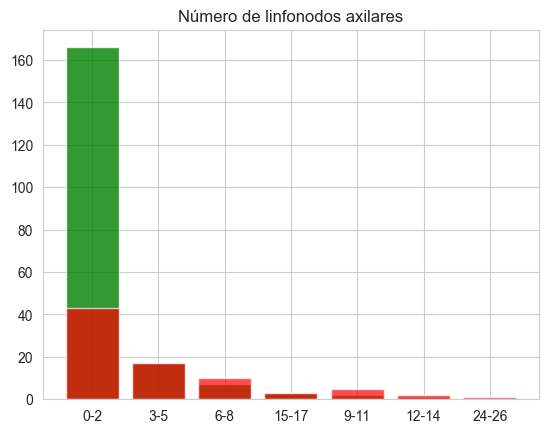

In [337]:
plotar_barras("linfonodos", "Número de linfonodos axilares")

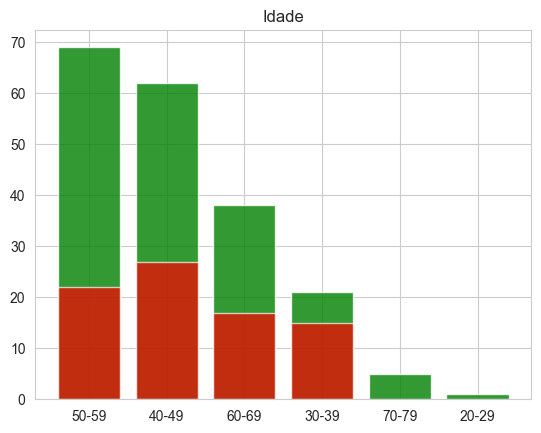

In [338]:
plotar_barras("idade", "Idade")

### Lidando com dados descritivos

In [339]:
df = pd.get_dummies(data=df, columns=colunas_descritivas)
for column in df.columns:
    df[column] = df[column].apply(lambda x: int(x) if type(x) == bool else x)
df

,saida,penetracao_linfonodo,grau_malignidade,radioterapia,idade_20-29,idade_30-39,idade_40-49,idade_50-59,idade_60-69,idade_70-79,...,tamanho_tumor_45-49,tamanho_tumor_5-9,tamanho_tumor_50-54,linfonodos_0-2,linfonodos_12-14,linfonodos_15-17,linfonodos_24-26,linfonodos_3-5,linfonodos_6-8,linfonodos_9-11
0,0,0,3,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,2,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,2,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,2,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,2,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,1,0,2,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
282,1,0,3,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
283,1,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
284,1,0,3,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Padronização

A técnica de padronização Z-score foi escolhida para a coluna "grau_malignidade" porque a distribuição dos dados é equilibrada, com aproximadamente 45,45%, 29,72% e 24,83% dos casos correspondendo aos graus de malignidade 2, 3 e 1, respectivamente.

In [340]:
media = df["grau_malignidade"].mean()
desvio = df["grau_malignidade"].std()
df["grau_malignidade"] = df["grau_malignidade"].apply(lambda x: (x - media) / desvio)
df.head(3)

,saida,penetracao_linfonodo,grau_malignidade,radioterapia,idade_20-29,idade_30-39,idade_40-49,idade_50-59,idade_60-69,idade_70-79,...,tamanho_tumor_45-49,tamanho_tumor_5-9,tamanho_tumor_50-54,linfonodos_0-2,linfonodos_12-14,linfonodos_15-17,linfonodos_24-26,linfonodos_3-5,linfonodos_6-8,linfonodos_9-11
0,0,0,1.290757,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,-0.079127,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,-0.079127,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


# Divisão de treino e teste

In [341]:
X = df.drop(columns=["saida"])
y = df.saida

In [342]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=SEED
)

# Execução do KNN

## Por que KNN?

O KNN é um algoritmo de aprendizado **supervisionado** que requer a existência de classes pré-definidas.

Como as classes já estão definidas esse algoritmo é a escolha mais elegante.

Testando melhor número de vizinhos

In [343]:
vizinhos = list(range(1, 41))

pontuacao = []

for v in vizinhos:
    knn = KNeighborsClassifier(n_neighbors=v)

    # A escolha de 10 para a validação cruzada permite uma avaliação mais precisa do desempenho
    # do modelo em dados não vistos e uma redução no risco de sobreajuste ao conjunto de treinamento.
    pontos = cross_val_score(knn, X_train, y_train, cv=10, scoring="accuracy")
    pontuacao.append(pontos.mean())

melhor_v = vizinhos[pontuacao.index(max(pontuacao))]

print(f"Melhor número de vizinhos: {melhor_v}")

Melhor número de vizinhos: 15


In [344]:
knn = KNeighborsClassifier(n_neighbors=melhor_v)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
precisao_knn = accuracy_score(y_test, y_pred)
print(f"Precisão do modelo: {porcentagem(precisao_knn)}")

Precisão do modelo: 80.0%


# Execução da Rede Neural

In [345]:
n_entradas = len(X.columns)
n_saidas = 1  # 0 ou 1

n_neuronios = int((n_entradas + n_saidas) / 2)

print(
    f"Número de entradas: {n_entradas}, número de neurônios ocultos: {n_neuronios} e número de saídas: {n_saidas}"
)

Número de entradas: 30, número de neurônios ocultos: 15 e número de saídas: 1


## Número de camadas e quantidade de neurônios ocultos


As quantidades foram baseadas nas formulas apresentadas pelo professor em sala de aula.

### 1º Formula:

$N_{neurônios} = \frac{(n_{entrada} + n_{saida})}{2}$

### 2º Formula:

$N_{neurônios} = \frac{2}{3} n_{entrada} + n_{saida}$

### 3º Formula:

$N_{neurônios}< 2 \cdot n_{entrada}$

A 1ª foi escolhida pois foi a mais precisa durante os testes.

## Diagrama da rede neural

![Rede neural com 7 entradas, com duas camadas de 4 neurônios e 1 saída.](./imagens/nn.svg)

In [346]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(
            n_neuronios, activation="relu", input_shape=(n_entradas,)
        ),
        tf.keras.layers.Dense(
            n_neuronios, activation="relu"  # Função de ativação eficiênte
        ),
        tf.keras.layers.Dense(n_saidas, activation="sigmoid"),  # Saída será 0 ou 1
    ]
)

Para após 20 perdas de validação seguidas e salva o melhor modelo após a execução da rede. 

In [347]:
parada = EarlyStopping(monitor="val_loss", patience=20)
checkpoint = ModelCheckpoint(
    filepath="./MelhorModelo.h5", monitor="accuracy", save_best_only=True
)

In [348]:
# A função de custo utilizada foi a binary cross-entropy pois a saída sempre será 0 ou 1.
# O algoritmo de otimização escolhido foi o Adam pois ele é eficiente com baixas quantidades de dados.

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [349]:
def imprimir_epoca(epoca, logs):
    print(
        f"Época {epoca} - perda de treinamento: {logs['loss']:.4f} - precisão de treinamento: {logs['accuracy']:.4f} - perda de validação: {logs['val_loss']:.4f} - precisão de validação: {logs['val_accuracy']:.4f}",
        end="\r",
    )


callbacks = [parada, checkpoint, LambdaCallback(on_epoch_end=imprimir_epoca)]

500 épocas devido a configuração de parada definida anteriormente.

In [350]:
historico = model.fit(
    X_train,
    y_train,
    epochs=500,
    validation_data=(X_test, y_test),
    use_multiprocessing=True,
    callbacks=callbacks,
    verbose=False,
)

In [351]:
_, precisao_rede_neural = model.evaluate(X_test, y_test)
print(f"Precisão: {porcentagem(precisao_rede_neural)}")

3/3 [==============================] - 0s 1ms/step - loss: 0.4184 - accuracy: 0.8143
Precisão: 81.43%


# Precisão

In [352]:
print(
    f"Precisão do KNN: {porcentagem(precisao_knn)}, precisão da rede neural: {porcentagem(precisao_rede_neural)}"
)

Precisão do KNN: 80.0%, precisão da rede neural: 81.43%


In [353]:
pd.DataFrame(historico.history)

,loss,accuracy,val_loss,val_accuracy
0,0.700508,0.492754,0.698094,0.428571
1,0.683898,0.565217,0.681086,0.571429
2,0.670375,0.647343,0.665517,0.585714
3,0.657632,0.695652,0.650911,0.700000
4,0.645457,0.714976,0.638151,0.728571
...,...,...,...,...
97,0.356287,0.855072,0.415380,0.828571
98,0.354338,0.855072,0.415259,0.828571
99,0.352224,0.855072,0.415759,0.828571
100,0.349755,0.850242,0.416715,0.828571
